In [1]:

import argparse
from transformers import AutoImageProcessor, AutoModelForImageClassification
from evaluate import load as load_metric
from datasets import Dataset, load_from_disk
from PIL import Image, ImageFile
from sklearn.metrics import classification_report
import numpy as np
ImageFile.LOAD_TRUNCATED_IMAGES = True #imagenes ligeramente corruptas OK

import torch
import torch.nn as nn

model_location="MimModels/swinv2-base-patch4-window16-256-popo/checkpoint-21700/"
model = AutoModelForImageClassification.from_pretrained(model_location).to("cuda")
image_processor = AutoImageProcessor.from_pretrained(model_location)

In [2]:
dataset=load_from_disk("popocatepetl-eval-dataset/")#["test"]

In [3]:
l2id={n:i for i,n in enumerate(dataset.features["labels"].names)}

In [4]:
def classify(data):
    inputs=image_processor(images=data["image"], return_tensors="pt")["pixel_values"].to(model.device)
    logits=model(pixel_values=inputs).logits
    probabilities = nn.functional.softmax(logits, dim=-1)
    probabilities = probabilities.detach().cpu().numpy().flatten()
    predicted_class_idx = logits.argmax(-1).item()
    #return predicted_class_idx
    return l2id[model.config.id2label[predicted_class_idx]]

In [5]:

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")
    
val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            # normalize,
        ]
    )

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

#dataset.set_transform(preprocess_val)

In [6]:
from fastprogress import progress_bar as pb
results=[]
expected=[]
for row in pb(dataset):
    try:
        class_=classify(row)
        results.append(class_)
        expected.append(row["labels"])
        #print(class_,model.config.id2label,row["labels"],dataset.features["labels"].names)
    except Exception as e:
        #print(e)
        pass

In [7]:
report=classification_report(results,expected,labels=np.unique(results).tolist(),target_names=dataset.features["labels"].names, output_dict=True)
report

/home/miriam/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2642: UserWarning: labels size, 4, does not match size of target_names, 5
  warnings.warn(


{'EXP+FUM': {'precision': 0.7714285714285715,
  'recall': 0.8709677419354839,
  'f1-score': 0.8181818181818182,
  'support': 93.0},
 'UNK': {'precision': 0.6976744186046512,
  'recall': 0.9375,
  'f1-score': 0.8,
  'support': 32.0},
 'FUM': {'precision': 0.8117647058823529,
  'recall': 0.6831683168316832,
  'f1-score': 0.7419354838709677,
  'support': 101.0},
 'INA': {'precision': 1.0,
  'recall': 0.5882352941176471,
  'f1-score': 0.7407407407407407,
  'support': 17.0},
 'accuracy': 0.7818930041152263,
 'macro avg': {'precision': 0.8202169239788939,
  'recall': 0.7699678382212036,
  'f1-score': 0.7752145106983817,
  'support': 243.0},
 'weighted avg': {'precision': 0.7944719087749943,
  'recall': 0.7818930041152263,
  'f1-score': 0.7786789528990511,
  'support': 243.0}}

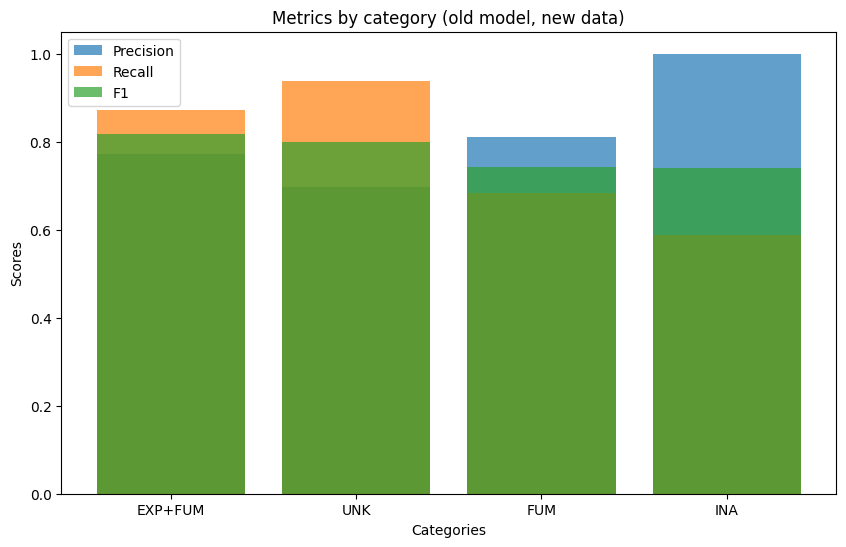

In [8]:
import matplotlib.pyplot as plt
categories = [dataset.features["labels"].names[i] for i in np.unique(results).tolist()]

precision_values = [report[cat]['precision'] for cat in categories]
recall_values = [report[cat]['recall'] for cat in categories]
f1_values = [report[cat]['f1-score'] for cat in categories]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, precision_values, label=f'Precision', alpha=0.7)
plt.bar(categories, recall_values, label=f'Recall', alpha=0.7)
plt.bar(categories, f1_values, label=f'F1', alpha=0.7)

plt.xlabel('Categories')
plt.ylabel('Scores')
plt.title('Metrics by category (old model, new data)')
plt.legend()
plt.savefig("old_model_metrics_nd")
plt.show()